## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob, os
import matplotlib.pyplot as plt
%matplotlib inline

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Followed the lesson instruction on calibration. onbpoints and corresponding images points are calulated using the chessboard images using opencv findChessboardCorners function. These objpoints and imgpoints are used to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function


In [2]:
def camera_caliberation(nx = 9, ny = 6):
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)


    #cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx, dist)

Compute the calibration and distortion coefficients

In [3]:
#Compute camera caliberation
mtx, dist = camera_caliberation()

def cal_undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Testing the calibration

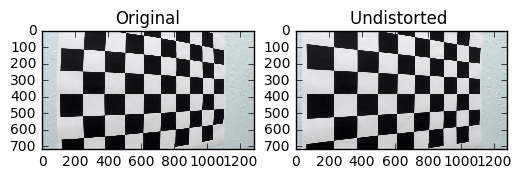

In [4]:
img = cv2.imread("./camera_cal/calibration5.jpg")
undistorted_img = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted ')



## Pipeline (single images)
### 1. Provide an example of a distortion-corrected image.


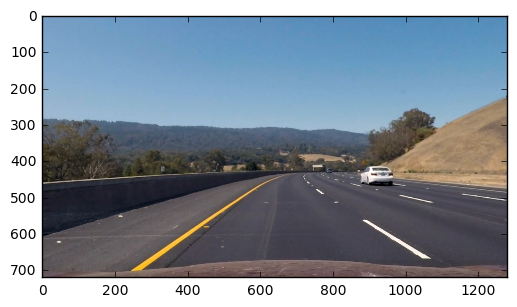

In [5]:
# Applying undistort on test image
test3 = cv2.imread("./test_images/test3.jpg")
undistorted_test3 = cal_undistort(test3, mtx, dist)

rgb_img = cv2.cvtColor(undistorted_test3, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I'm using combination of gradient threshold on gray image and color thresholding of L channel in HLS.

In [6]:
def color_gradient_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

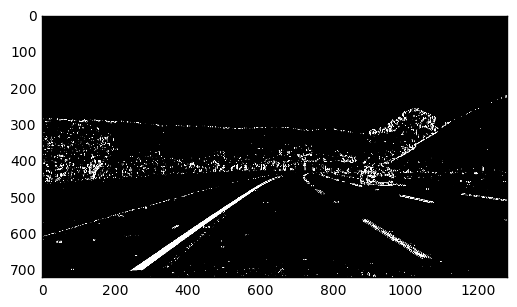

In [7]:
# Threshold the test image 

threshold_test3 = color_gradient_binary(undistorted_test3)

plt.imshow(threshold_test3, cmap="gray")

### Region of interest

I used the region of interest concept from the first project to isolate the lane lines 

In [8]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

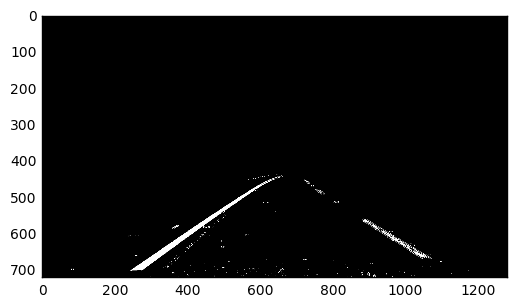

In [15]:
 # Region of interest mask
imgWidth = threshold_test3.shape[1]
imgHeight = threshold_test3.shape[0]

vertices =  np.array([[(0, imgHeight),  # bottom left
                       (imgWidth * 0.47, imgHeight * 0.60), # top left
                       (imgWidth * 0.53, imgHeight * 0.60), # top right
                       (imgWidth, imgHeight)]], dtype=np.int32) # bottom right

binary_test3 = region_of_interest(threshold_test3, vertices)
plt.imshow(binary_test3, cmap="gray")

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

I used the straight_lines.jpg image in the test folder to manually come up with the src and dst points for the warping. The points are hardcoded in the code



In [16]:
def warp_image(img, inverse= False):
    src = np.float32([[180, 720],
                      [600, 445],
                      [680, 440],
                      [1120, 720]])
    dst = np.float32([[300, 720],
                      [300, 0],
                      [950, 0],
                      [950, 720]])

    # Given src and dst points, calculate the perspective transform matrix
    if (inverse == False) :
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped 

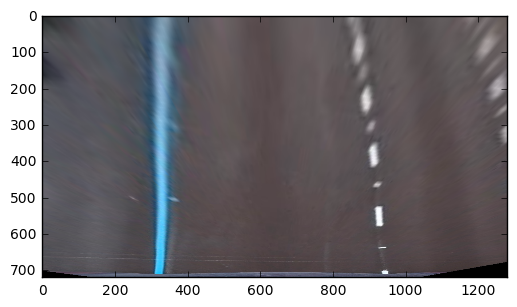

In [28]:
# Test the warping on the straight line image
straight_img = cv2.imread("./test_images/straight_lines1.jpg")
warped_straight = warp_image(straight_img)
plt.imshow(warped_straight)

Now let's warp the test image



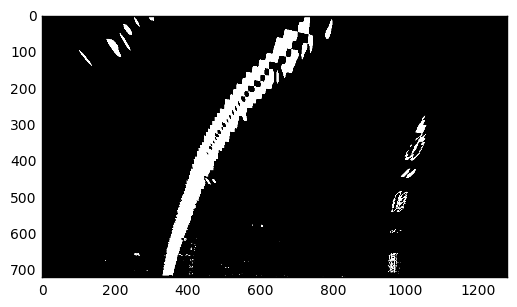

In [29]:
warped_test3 = warp_image(binary_test3)
plt.imshow(warped_test3, cmap="gray")

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [30]:
binary_warped = warped_test3

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Let's run the above code which identifies the lane line pixel positions using sliding window technique on our test image and visualize it.

(720, 0)

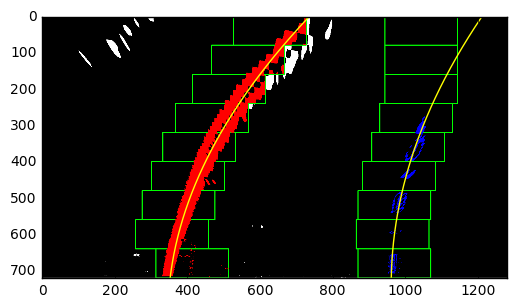

In [20]:

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I'm using the parameters suggested in the lecture to convert the pixel values to real world. I'm  using y value as 720 which is bottom of the image._

In [27]:
#Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/650 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
y_eval = 720
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("Radius of curvature:")
print(left_curverad, 'm', right_curverad, 'm')


Radius of curvature:
267.412160767 m 333.124505108 m


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

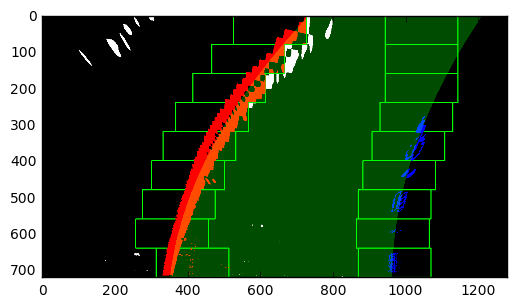

In [22]:
left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
binary_warped_zero = np.zeros_like(binary_warped).astype(np.uint8)

lanes_warped = np.dstack((binary_warped_zero, binary_warped_zero, binary_warped_zero))
lane_pts = np.hstack((left_line, right_line))

# Draw the lane onto the warped blank image
cv2.fillPoly(lanes_warped, np.int_([lane_pts]), (0,255, 0))
warped_result = cv2.addWeighted(out_img, 1, lanes_warped, 0.3, 0)
plt.imshow(warped_result)

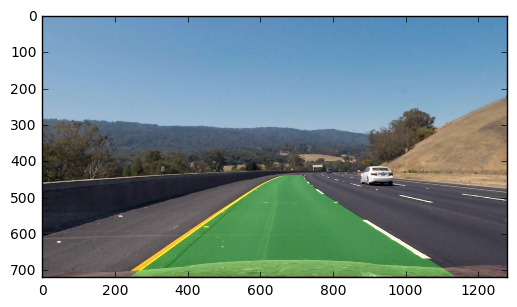

In [23]:
unwarped_result = cv2.addWeighted(undistorted_test3, 1, warp_image(lanes_warped, True), 0.3, 0)
rgb_img = cv2.cvtColor(unwarped_result, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

### Pipeline
Using the above peices of code I have built the pipeline in the source/lane_detection.py file.

First I tested the pipeline on the test images. The function test_images() in the source/lane_detection.py processes the test images and writes the output in the output_images folder. There are sub folders in the output_images folder showing the results of intermediate operations like thresholding, warping etc.

#### Region of Interest
During the testing I found that using the region of interest mask from project line makes the pipeline more robust by ignoring the adjascent lane lines.

#### Video processing:

While processing the video, I'm using Line() class to store the previous frame informtion. I'm avearaging the lane lines from previous 10 frames to generate a smooth non jittery result. For polynomial fit, I have used the optimization of searching only partial area of the frames based on previous frame. The function find_lane_lines() searches the whole frame and find_lane_lines_efficient() seraches the in the area of previous frame lines.  Also I calculate the width between lane lines in pixels. If its below certain threshold then I reject the result of find_lane_lines_efficient() and fallback to find_lane_lines() function for polynomial fit.

See the project_video_output.mp4 for the final result.


#### Improvements: 
The above pipeline works very well with the project_video but doesn't perform well with challenge video. I think following improvements will make the pipeline more robust so that it will work with challenge videos also

1. Detect the outlier lines by checkin


In [37]:
from IPython.display import HTML

HTML("""
<video width="1280" height="720" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>
""")